In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from itertools import izip

plt.rcParams["figure.figsize"] =(10,4)

In [3]:
def fst(lst): return [ele[0] for ele in lst ];
def snd(lst): return [ele[1] for ele in lst ];

In [4]:
def k(x,y,alpha=2,sigma2=2): #alpha=1: Laplace kernel. alpha=2: Gaussian
    #return pow(np.linalg.norm(x),alpha) + pow(np.linalg.norm(y),alpha) - pow(np.linalg.norm(x-y),alpha)
    return 1.*np.exp(-pow(np.linalg.norm(x-y),alpha)/sigma2)

In [5]:
def h(x1, y1, x2, y2): #See p. 729 in "a kernel two sample test"
    return k(x1, x2) + k(y1, y2) - k(x1, y2) - k(x2, y1)

In [6]:
def sqrt(x):
    return np.sqrt(x)

In [7]:
def refgen():
    return sigma1*np.random.randn() + mu1

In [8]:
# Function to generate a random sequence.
# The sequence may or may not have a change point,
# (mu1,sigma1) are the distribution parameters before the change,
# (mu2,sigma2) are the parameters after the change.
def sequence_generator(length, 
                       change_point=None, 
                       seed = None): #ret[change_point] = 1st new pt 

    if seed is None: 
        seed =  random.randrange(2**32 -1 )
    np.random.seed(seed)
    print("Seed was:", seed)
    
    if change_point == None: change_point = length
    i=0;
    while i < length:
        if i < change_point:
            yield sigma1*np.random.randn() + mu1
        else:
            yield sigma2*np.random.randn() + mu2
        i = i + 1

In [30]:
def np_generator(seq,delta,sigma2=2): #delta: threshold needed for detectors to continue.
    
    kyy = []
    kxy = []
    kxx = [] 
    
    S = []
    n = 0
    active = []
    hist = []
    numterms = []
    zz = []
    
    for x in seq:
        # Update the already active tests   
        stillactive = []
        for a in active: # a is the test that seq[a],seq[a+1], ... are distributed according to the alternative.
                         # len(hist) will be n.
                         # so we are comparin seq[0], ..., seq[a-1] with seq[a],...,seq[n]
                    
            if a == n-1: 
                stillactive.append(a)
                continue;
                
            for i in range(3):
                kxy[a] += k(x, np.random.choice( hist[:a+1]),sigma2=sigma2)
                kyy[a] += k(x, np.random.choice( hist[a+1:]),sigma2=sigma2)
                numterms[a] = numterms[a] + 1;
            coeff = sqrt(a)*(n-a) #sqrt(n-a)
            bias = -0.1
            S[a] = coeff*(kxx[a]/zz[a] + kyy[a]/numterms[a] - 2*kxy[a]/numterms[a] + bias )
            #print("NUmterms %d n-a+1 %d" %( numterms[a], n-a+1))
            if S[a] > delta:
                stillactive.append(a)
                
        active = stillactive
        # Start the test that the change occured at time n.
        kxxprev = 0
        zzprev = 0
                              
        if len(kxx) > 0:
            kxxprev = kxx[-1]
            zzprev = zz[-1]
            
        kxx.append(kxxprev + sum([ k(x,h,sigma2=sigma2) for h in hist])) #if n is 10 then we are adding 10
        zz.append(zzprev + len(hist))
                              
        #print("Hist len at %d is %d",n,len(hist))
        kxy.append(0) 
        kyy.append(0)
        numterms.append(0)
        hist.append(x)
        if n > 1:
            active.append(n) #n is regarded as the last point of the previous.
        S.append(0)
      
        
        # Increment data counter
        n = n + 1
        #if(n>100): print(S[100])
        yield (max(S), np.argmax(S), len(active), -1 if n <= 100 else S[100],  -1 if n <= 50 else S[50],  -1 if n <= 150 else S[150], - 1 if n<= 3 else S[3])
    #plt.plot(S,'.')

In [42]:
def go(a_seq,delta=-25,sigma2=2):
    plt.rcParams["figure.figsize"] =(15,5)

    plt.plot(a_seq)
    plt.title("Data")
    plt.figure()
    cz = np_generator(a_seq,delta=delta,sigma2=sigma2)

    n = 0 
    data = []
    nact= []
    amax = []
    s = []
    s50 = []
    s150 = []
    s3 = []
    for x in cz:
        if(len(x) < 6): continue;
        data.append(x[0])
        amax.append(x[1])
        nact.append(x[2])
        s.append(x[3])
        s50.append(x[4])
        s150.append(x[5])
        s3.append(x[6])
        #print("%d: %f" % (n,x))
        n = n + 1
        if(n>len(a_seq)): break

    plt.plot(data)
    plt.title("Max statistic value")

    plt.figure()
    plt.plot(amax,'.')
    plt.title("Location of max")

    plt.figure()
    plt.plot(nact,'.')
    plt.title("Number of detectors running")

    plt.figure()
    plt.plot(s)
    plt.title("S=100")

    plt.figure()
    plt.plot(s50)
    plt.title("S=50")

    plt.figure()
    plt.plot(s150)
    plt.title("S=150")

    plt.figure()
    plt.plot(s3)
    plt.title("S=3")

    print(amax)



## Change in variance

In [11]:
mu1 = 0; sigma1 = 1; mu2 = 0; sigma2= 3; cpt=500; 
#mu1 = 0; sigma1 = 1; mu2 = 0; sigma2=1.1; cpt=500;
a_seq = list(sequence_generator(length = 500,change_point =100)) #3176840365

('Seed was:', 3601216609)


[0, 0, 0, 0, 0, 3, 3, 2, 0, 7, 2, 9, 7, 7, 0, 0, 14, 13, 0, 0, 18, 12, 12, 12, 22, 18, 18, 18, 18, 18, 18, 22, 14, 14, 28, 24, 24, 28, 14, 14, 14, 14, 14, 41, 14, 14, 14, 14, 14, 43, 43, 44, 43, 43, 43, 43, 44, 44, 43, 43, 43, 43, 44, 43, 43, 43, 43, 43, 43, 43, 65, 65, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 43, 43, 61, 61, 61, 80, 72, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 94, 94, 94, 80, 91, 91, 91, 91, 91, 91, 94, 94, 94, 94, 91, 94, 94, 94, 91, 90, 94, 91, 91, 94, 94, 94, 91, 91, 91, 91, 91, 91, 91, 94, 94, 91, 91, 94, 94, 94, 94, 91, 91, 94, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 90, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 9

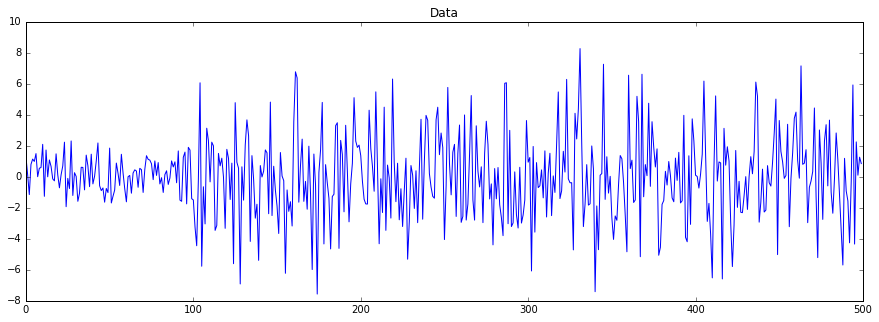

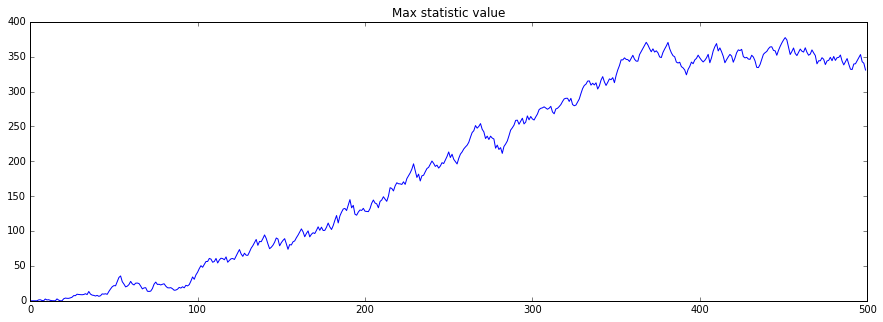

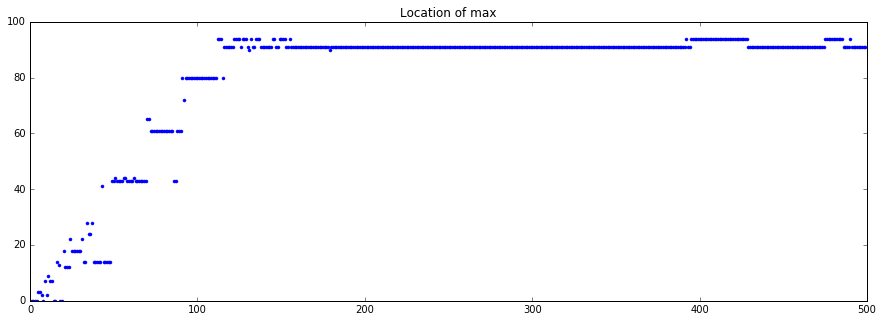

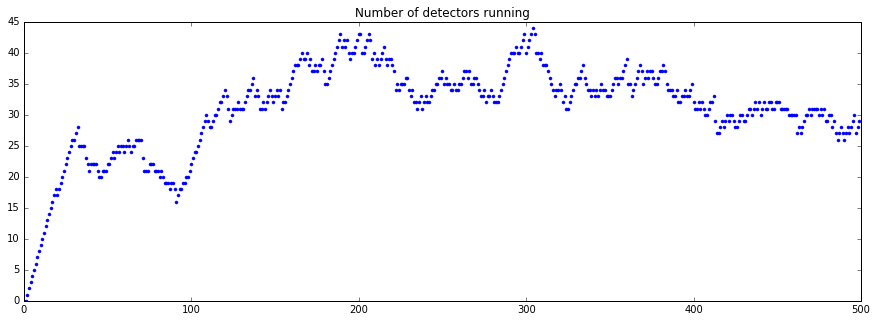

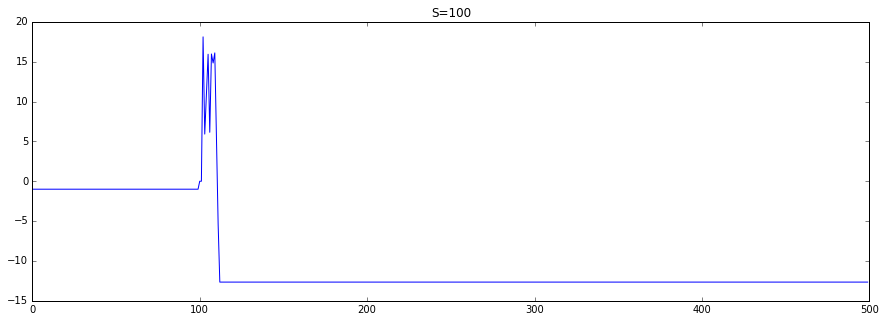

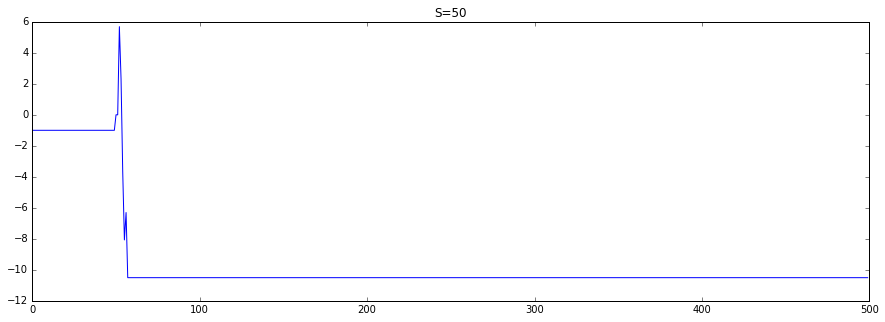

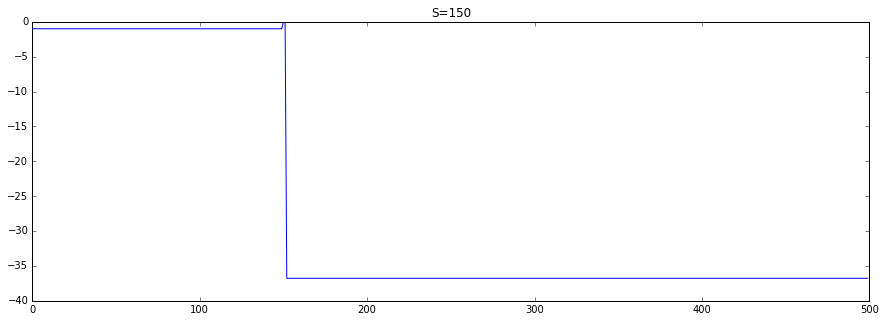

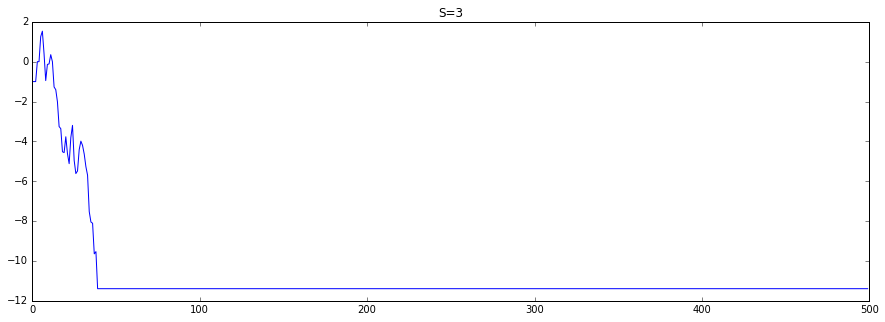

In [12]:
go(a_seq,delta=-10)

## Change in mean

('Seed was:', 1933110282)
[0, 0, 0, 0, 2, 0, 4, 3, 3, 7, 7, 7, 7, 7, 8, 8, 12, 12, 12, 17, 17, 19, 7, 7, 7, 19, 19, 7, 7, 24, 19, 19, 19, 27, 19, 19, 7, 7, 36, 36, 7, 7, 7, 40, 41, 38, 43, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 53, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 78, 78, 78, 78, 78, 78, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 100, 100, 100, 100, 78, 78, 72, 72, 72, 100, 100, 100, 100, 72, 72, 78, 78, 78, 78, 78, 101, 101, 101, 101, 101, 105, 101, 101, 105, 105, 105, 105, 105, 101, 101, 101, 101, 101, 105, 105, 105, 98, 98, 101, 101, 101, 101, 101, 101, 101, 101, 101, 105, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 1

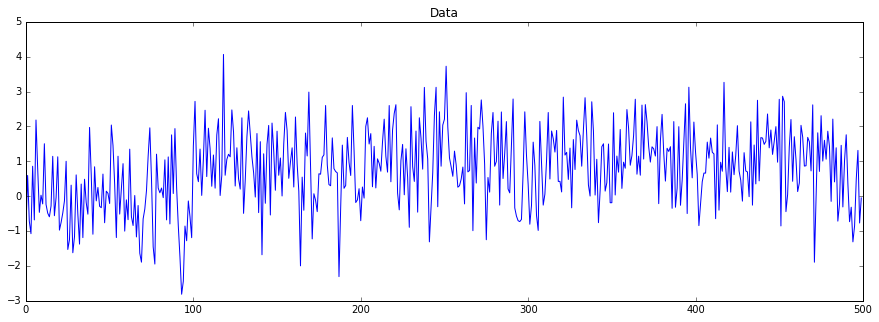

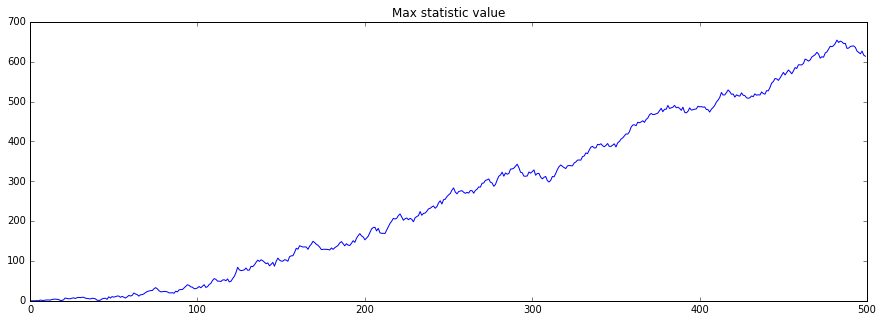

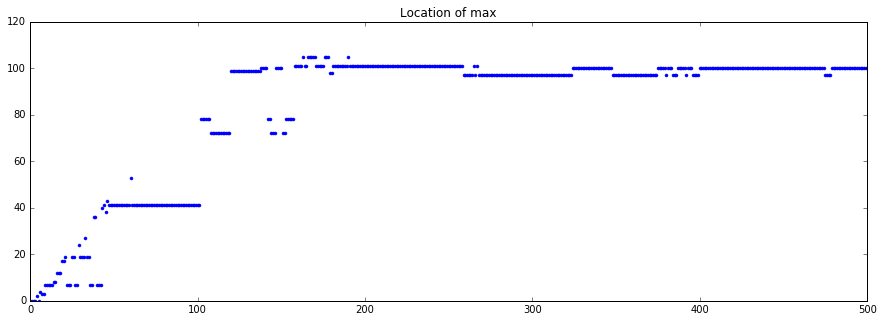

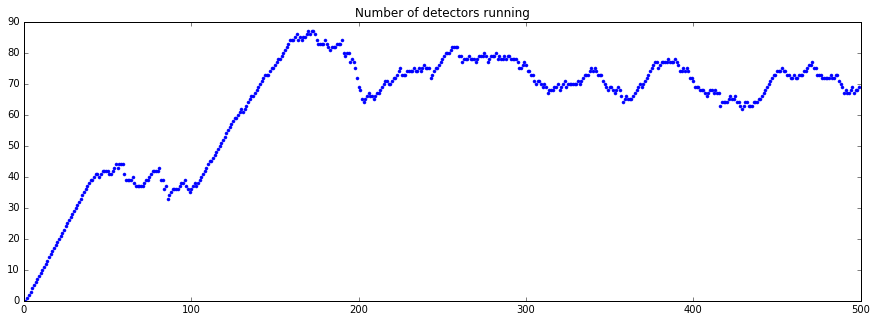

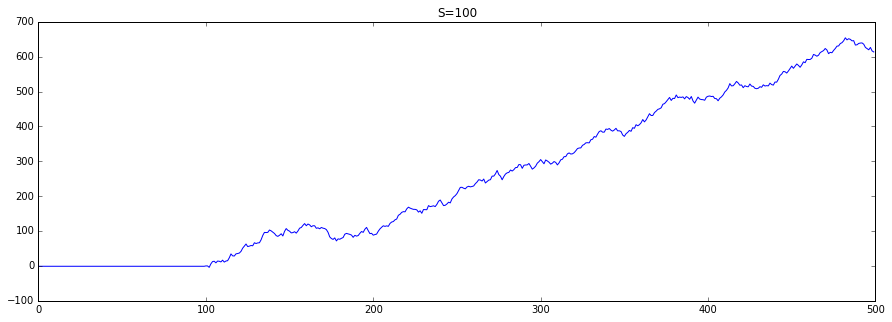

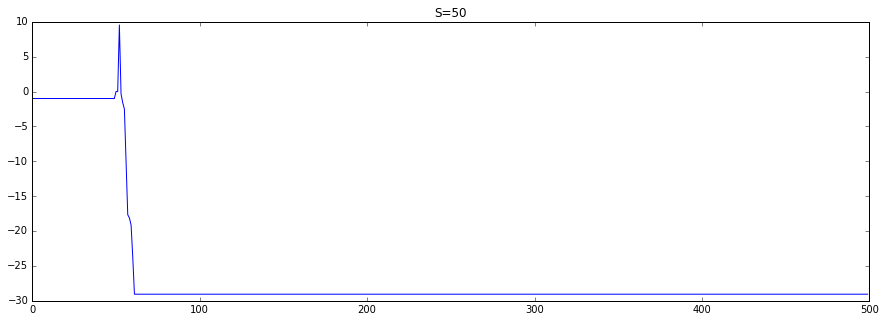

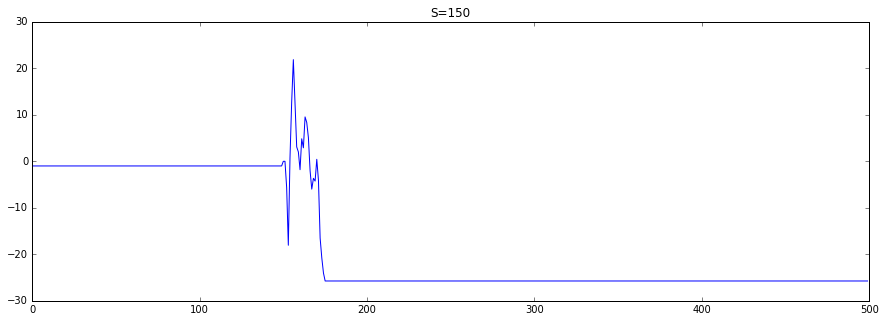

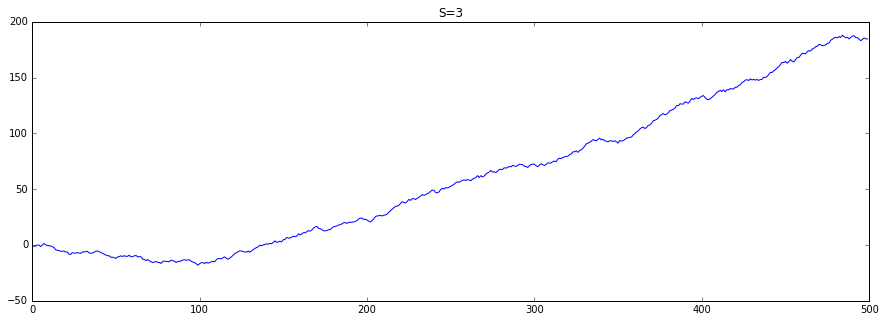

In [13]:
mu1 = 0; sigma1 = 1; mu2 = 1; sigma2= 1; cpt=500; 
#mu1 = 0; sigma1 = 1; mu2 = 0; sigma2=1.1; cpt=500;
a_seq = list(sequence_generator(length = 500,change_point =100))
go(a_seq)

## Real-world data

### Yahoo

In [107]:
import pickle
opp = pickle.load(open("../torch-version/data/cmu/yahoo-multi-change.pkl","r"))
inputs = opp['inputs'] #the sequences
targets = opp['targets']  #the change times for each sequence
types = opp['types'] #the type of the pre-change data.

Length: 1420 


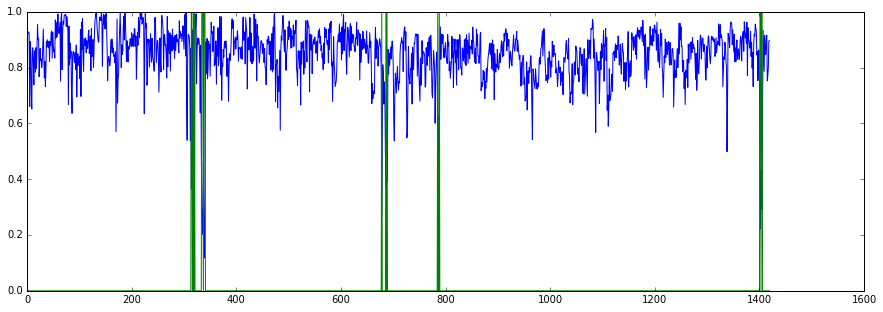

In [111]:
n=0
a_seq = inputs[n][:,0]
a_types=types[n]
print("Length: %d " % len(a_seq))
plt.plot(a_seq)
plt.plot(a_types)
#plt.axvline(a_target, linestyle = '--');

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 0, 0, 15, 0, 17, 0, 17, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 40, 0, 0, 41, 43, 0, 0, 46, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 77, 0, 0, 0, 0, 82, 82, 0, 0, 0, 0, 0, 0, 0, 0, 0, 93, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 120, 0, 0, 0, 0, 0, 0, 0, 0, 128, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 154, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 296, 296, 0, 0, 0, 0, 0, 0, 304, 0, 0, 0, 0, 0, 0, 0, 0, 313, 0, 0, 316, 316, 316, 316

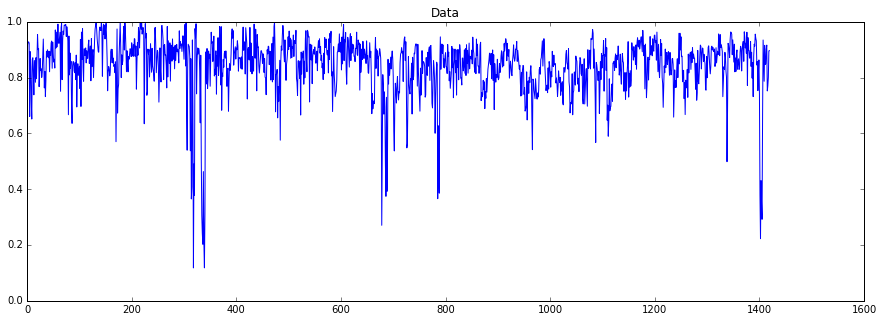

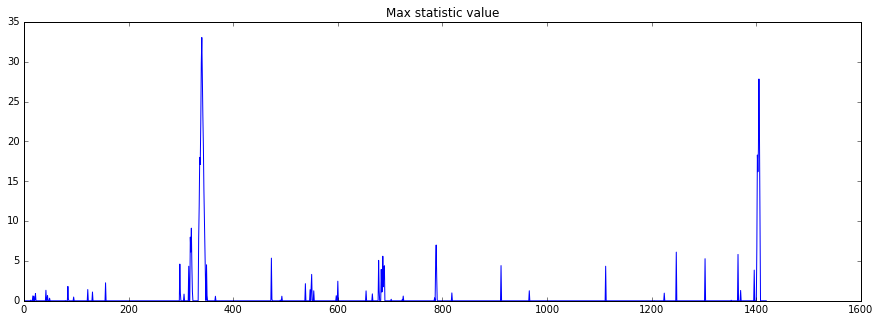

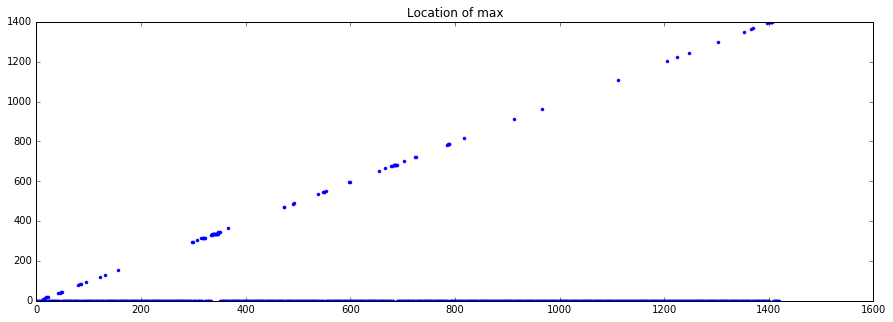

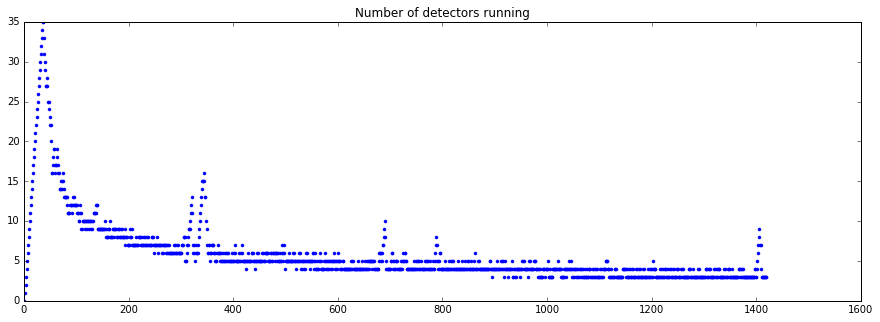

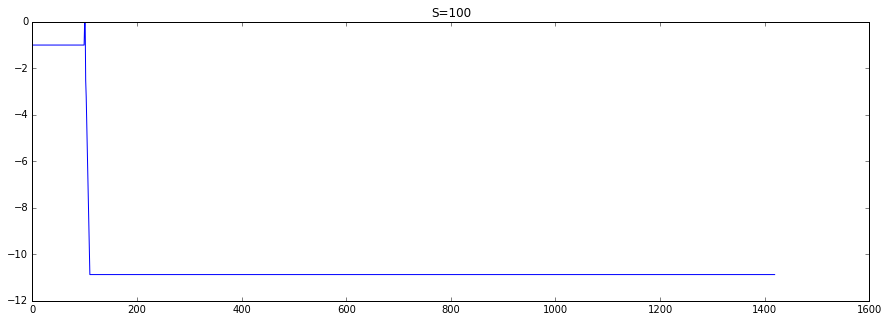

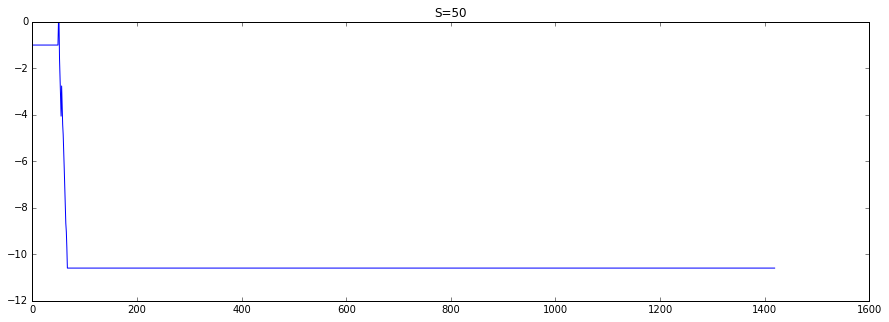

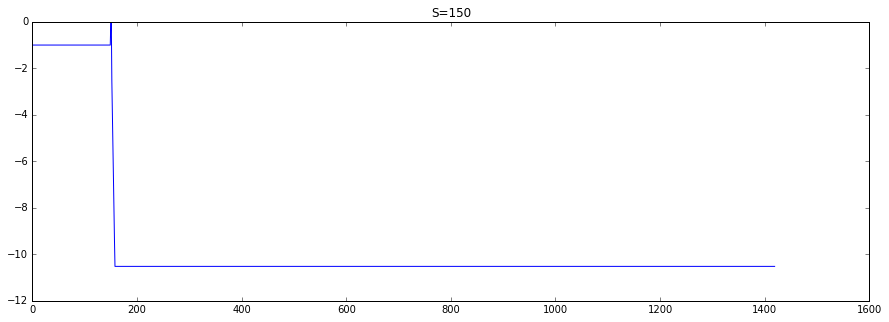

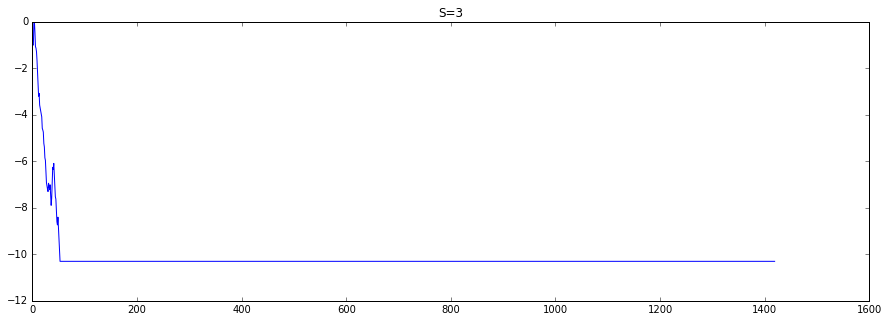

In [110]:
go(a_seq,delta=-10,sigma2=2)

### HASC

In [116]:
import pickle
opp = pickle.load(open("../torch-version/data/cmu/hasc-multi-change.pkl","r"))
inputs = opp['inputs'] #the sequences
targets = opp['targets']  #the change times for each sequence
types = opp['types'] #the type of the pre-change data.

Length: 39397 


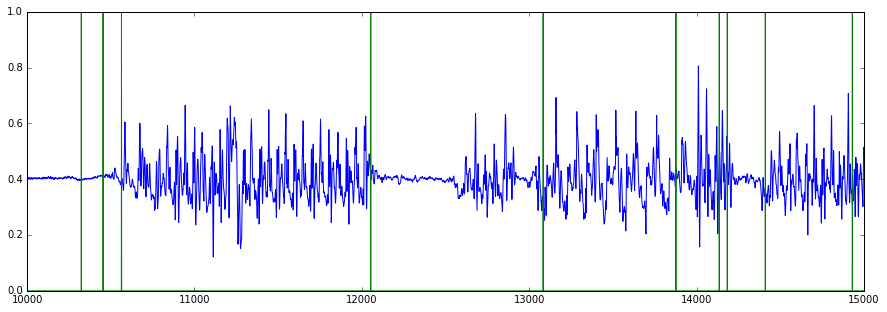

In [124]:
n=0
a_seq = inputs[n][:,0]
a_types=types[n]
print("Length: %d " % len(a_seq))

a=10000
b=15000
r=range(a,b)
plt.plot(r,a_seq[a:b])
plt.plot(r,a_types[a:b])
#plt.axvline(a_target, linestyle = '--');

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

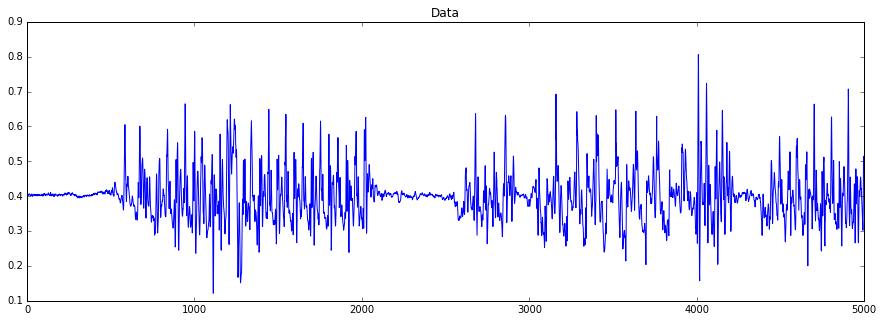

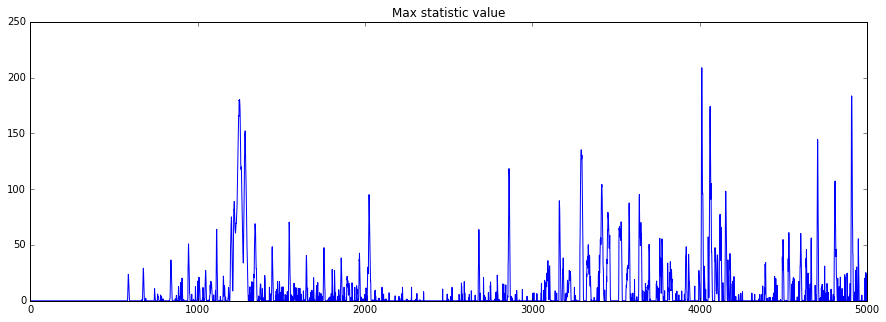

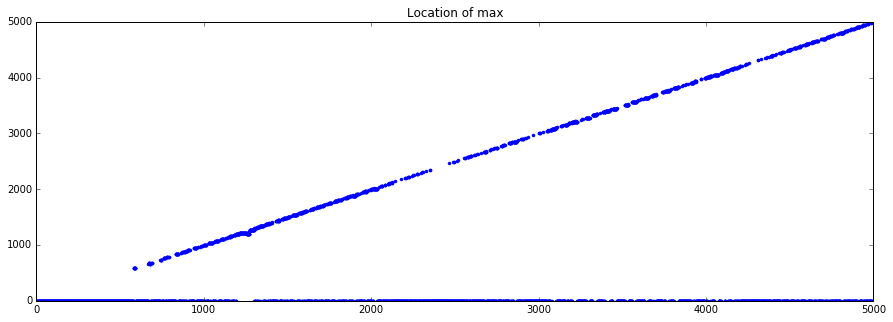

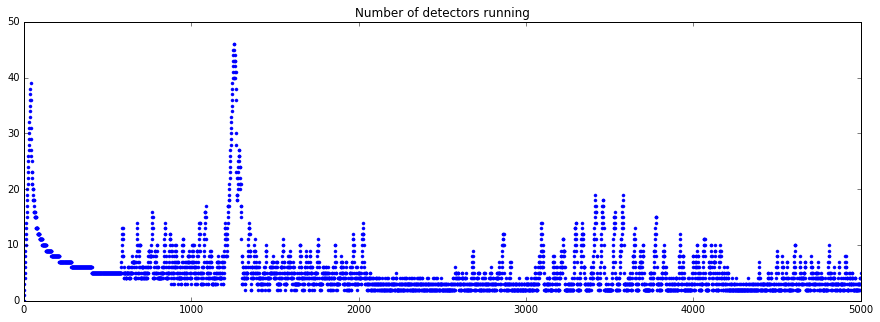

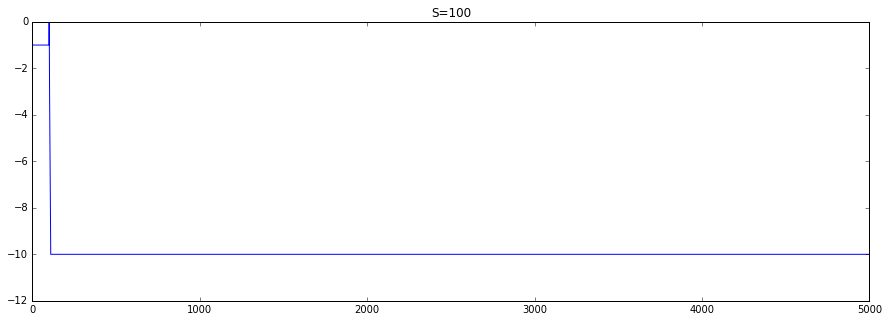

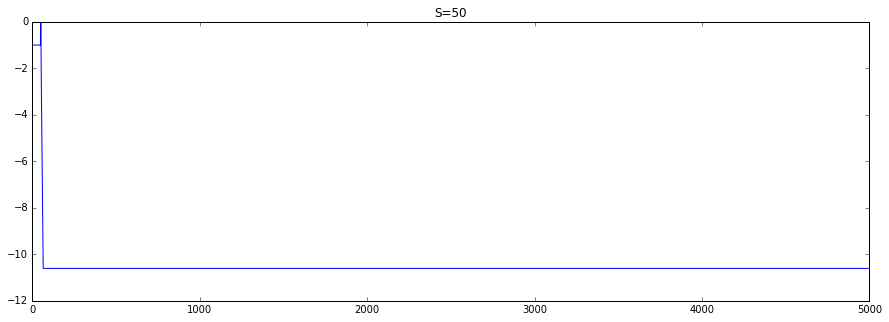

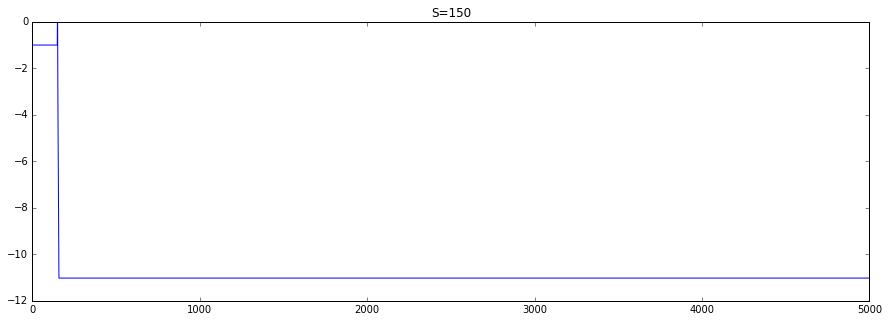

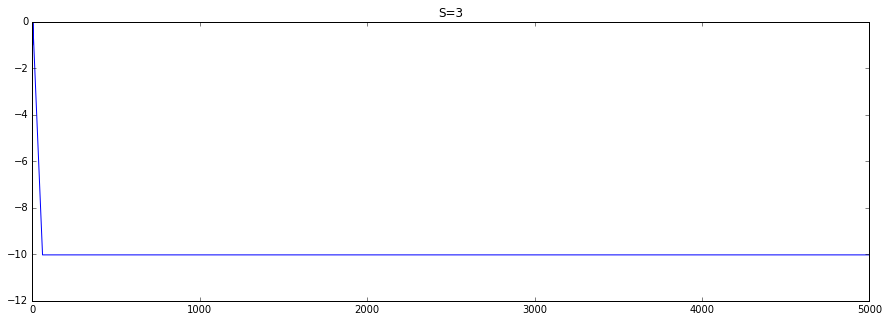

In [123]:
go(a_seq[10000:15000],delta=-10,sigma2=0.2)

### Fish killer

In [125]:
import pickle
opp = pickle.load(open("../torch-version/data/cmu/fish-multi-change.pkl","r"))
inputs  = opp['inputs'] #the sequences
targets = opp['targets']  #the change times for each sequence
types   = opp['types'] #the type of the pre-change data.

Length: 45175 


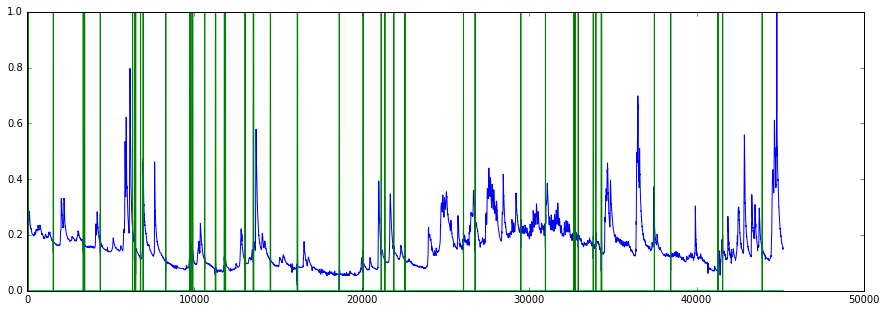

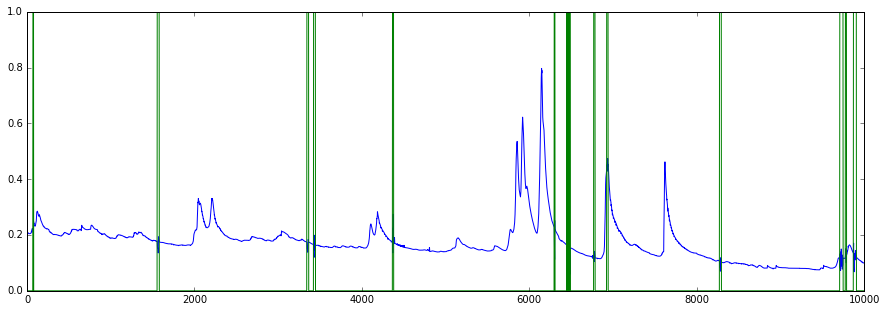

In [131]:
n=0
a_seq = inputs[n][:,0]
a_types=types[n]
print("Length: %d " % len(a_seq))
plt.plot(a_seq)
plt.plot(a_types)
#plt.axvline(a_target, linestyle = '--');
plt.figure()
a=0
b=10000
r=range(a,b)
plt.plot(r,a_seq[a:b])
plt.plot(r,a_types[a:b])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

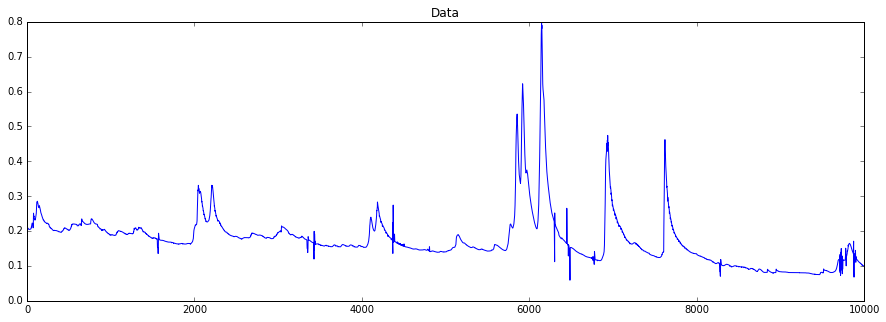

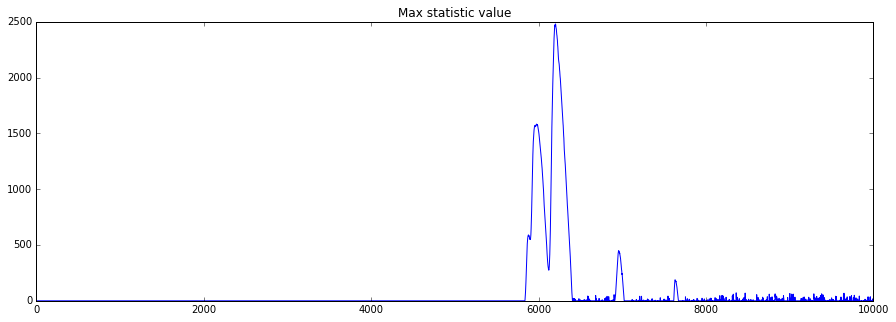

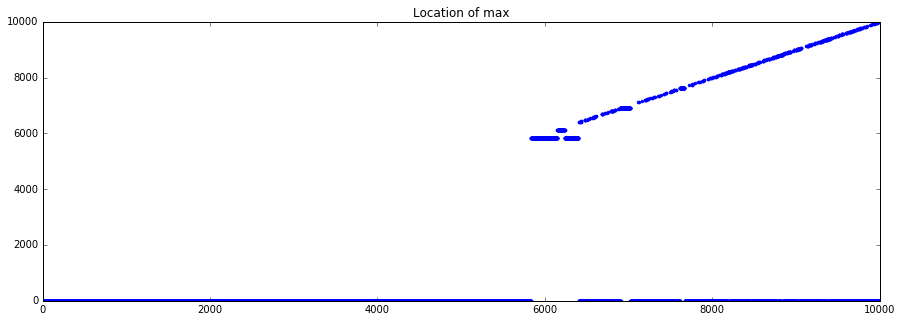

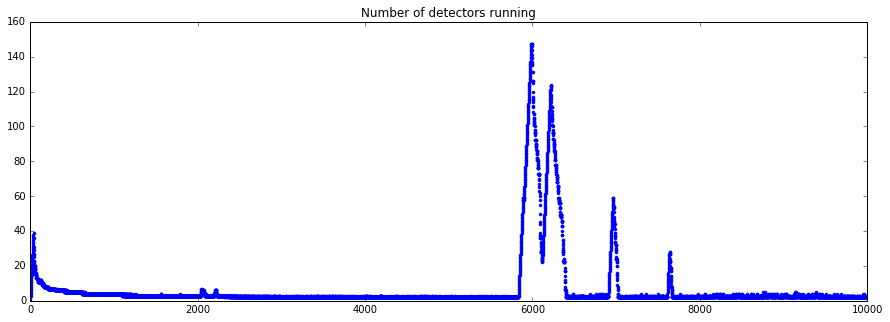

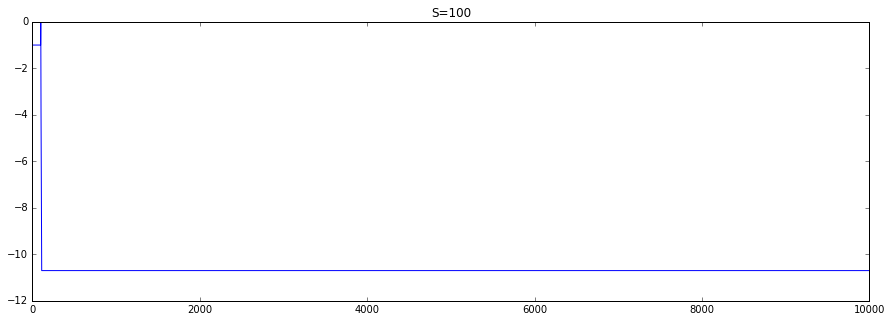

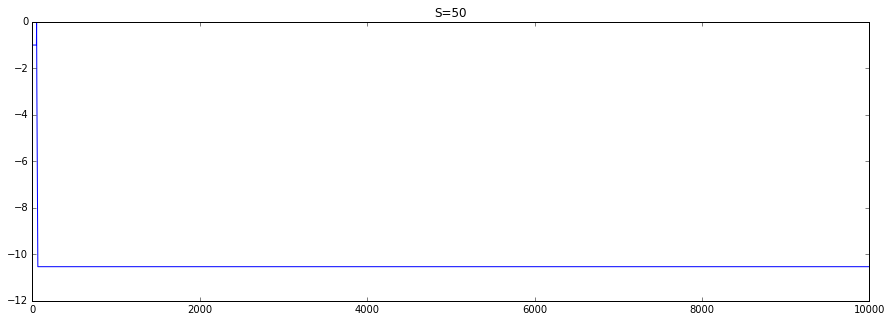

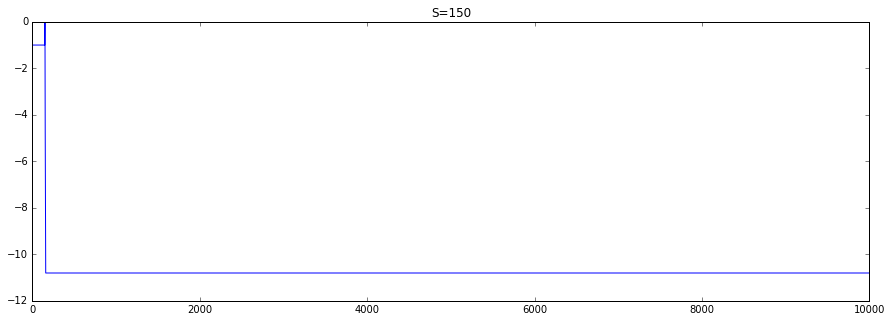

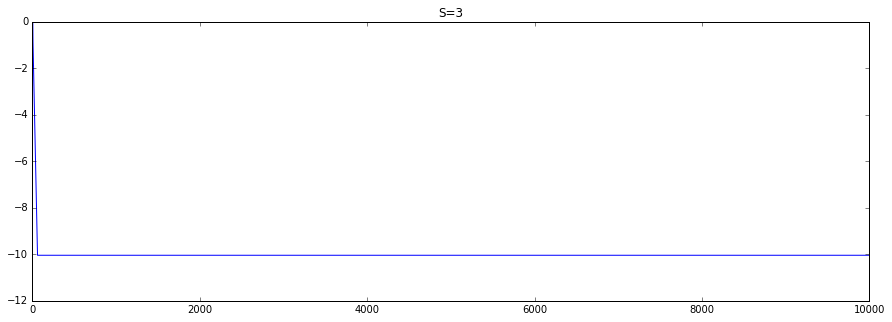

In [132]:
go(a_seq[:10000],delta=-10,sigma2=0.5)

### Bee

In [133]:
import pickle
opp = pickle.load(open("../torch-version/data/cmu/bee-multi-change.pkl","r"))
inputs  = opp['inputs'] #the sequences
targets = opp['targets']  #the change times for each sequence
types   = opp['types'] #the type of the pre-change data.

Length: 602 


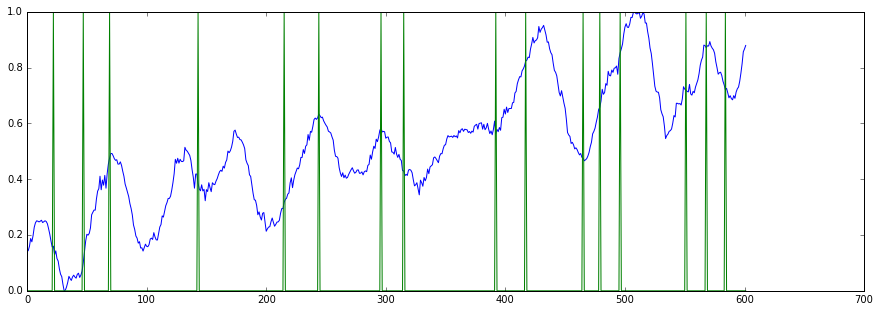

In [141]:
n=0
a_seq = inputs[n][:,1]
a_types=types[n]
print("Length: %d " % len(a_seq))
plt.plot(a_seq)
plt.plot(a_types)
#plt.axvline(a_target, linestyle = '--');
plt.figure()


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 57, 58, 58, 57, 57, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 122, 122, 121, 121, 123, 123, 122, 128, 128, 128, 122, 122, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 156, 0, 158, 0, 160, 0, 160, 0, 0, 0, 166, 161, 162, 162, 162, 170, 170, 162, 162, 162, 162, 170, 170, 170, 170, 169, 169, 169, 165, 165, 165, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 220, 0, 0, 0, 0, 0, 0, 0, 227, 229, 229, 227, 227, 233, 227, 229, 229, 229, 229, 229, 229, 227, 239, 231, 230, 230, 230, 230, 230, 230, 239, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232,

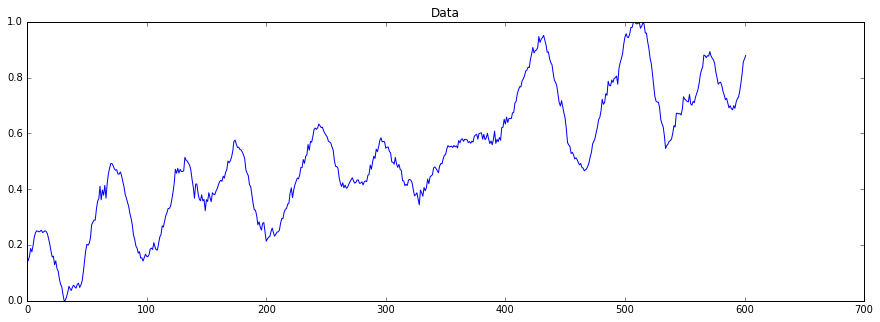

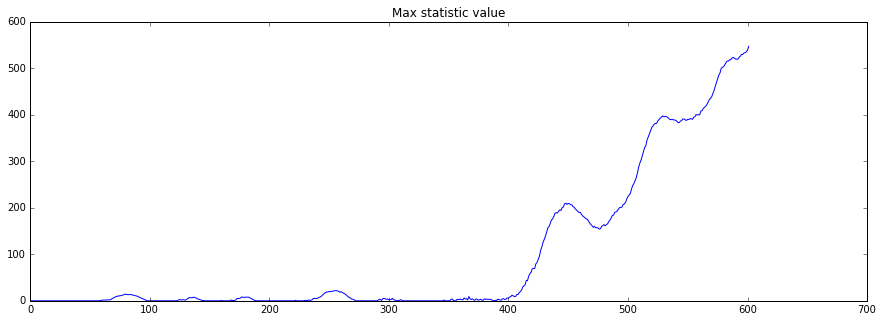

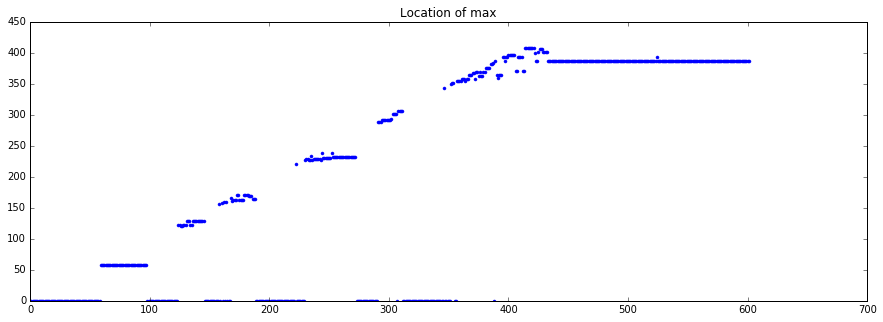

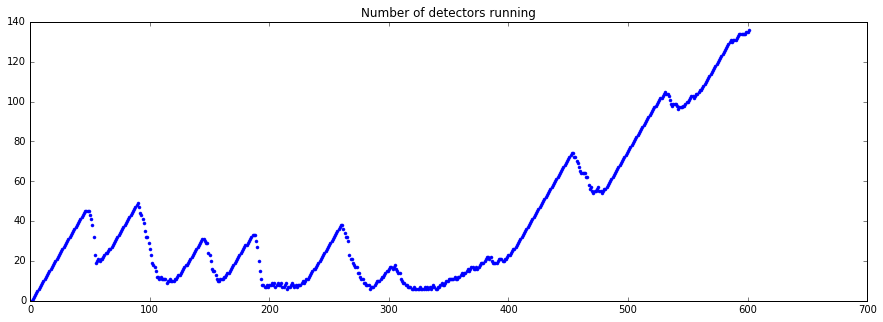

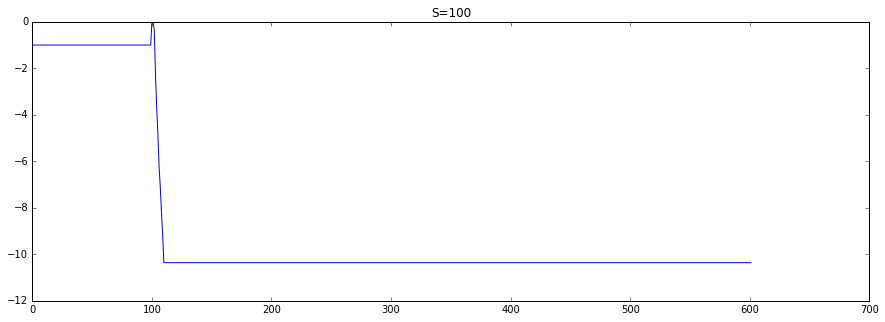

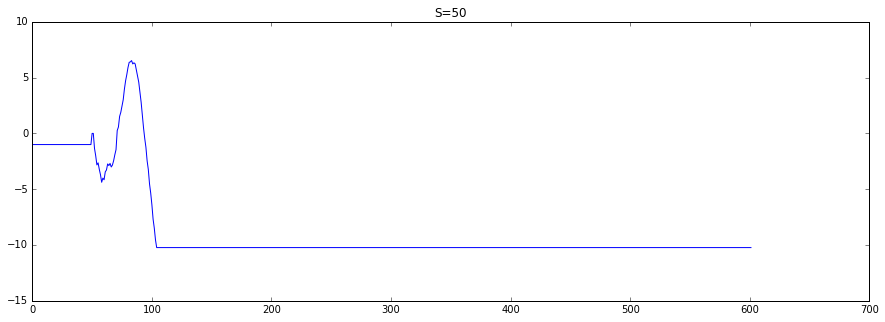

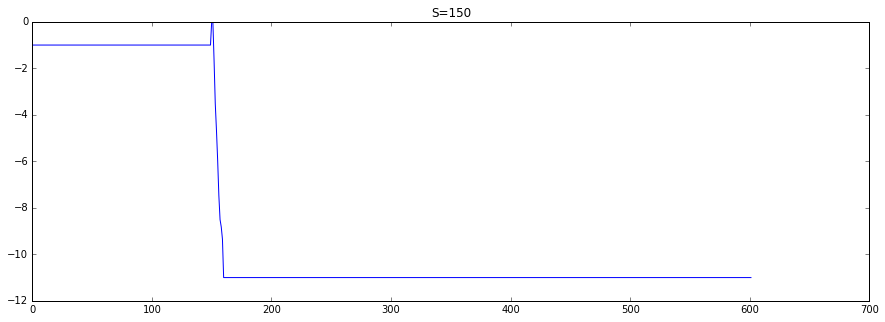

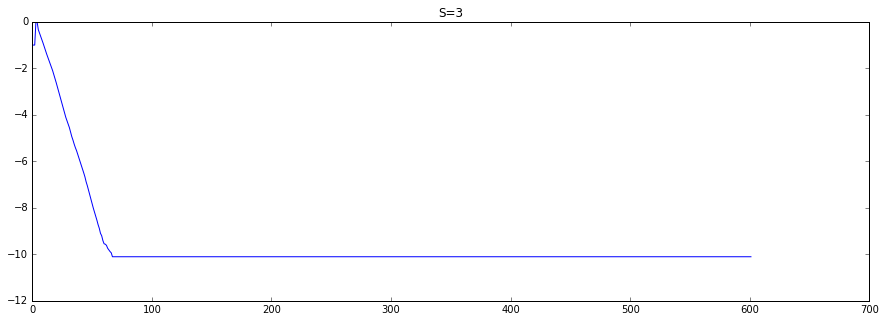

In [142]:
go(a_seq,delta=-10,sigma2=1)